# Neural Processes

Implementation of Neural Processes paper for Projects in Machine Learning and Artificial Intelligence course at TU Berlin

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rodrigobdz/neural-processes/blob/main/neural-processes.ipynb)

In [1]:
# Upload all .py files in neural_processes folder
# i.e. data_generator.py, decoder.py, encoder.py, mlp.py, model.py, and utils.py
from google.colab import files
uploaded = files.upload()

Saving __init__.py to __init__.py
Saving data_generator.py to data_generator.py
Saving decoder.py to decoder.py
Saving encoder.py to encoder.py
Saving img_model.py to img_model.py
Saving mlp.py to mlp.py
Saving mnist.py to mnist.py
Saving model.py to model.py
Saving plot.py to plot.py
Saving utils.py to utils.py


In [2]:
# Place uploaded files in neural_processes folder to mimic folder structure in repo
!rm -rf sample_data/
!mkdir -p neural_processes
!mv *.py neural_processes/

In [3]:
import neural_processes

In [4]:
import matplotlib.pyplot as plt

import torch
from torch import distributions
from torch import nn 
from torch import optim

import torchvision
from torchvision import datasets

In [5]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda')

In [6]:
TRAINING_ITERATIONS = 100 #@param {type:"number"}
MAX_NUM_CONTEXT = 50 #@param {type:"number"}
PLOT_AFTER = 100 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}

random_kernel_parameters=True #@param {type:"boolean"}

batch_size = 16
max_num_context = MAX_NUM_CONTEXT
x_size = 1
y_size = 1
length_scale = 0.6
sigma_scale = 1.0
num_iter = TRAINING_ITERATIONS
save_iter = PLOT_AFTER

### Training Data

In [7]:
gp = neural_processes.data_generator.GPCurves(batch_size, max_num_context, x_size, y_size, length_scale, sigma_scale, dev='cuda')
train_list = [gp.generate_curves() for _ in range(num_iter)]

### Output of 1D Gaussian Process data

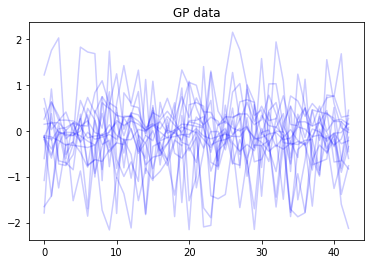

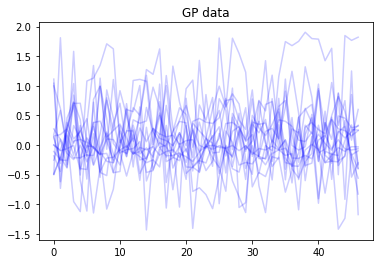

In [8]:
for batch in train_list[:2]:
  _, _, xt, yt = batch 
  for x, y in zip(xt, yt):
    plt.plot(y.cpu(), c='b', alpha=.2)
    plt.title(label='GP data')
    
  plt.show()

### Test Data

In [9]:
batch_size = 1
gptest = neural_processes.data_generator.GPCurves(batch_size, max_num_context, testing=True, dev='cuda')
test_list = [gptest.generate_curves() for _ in range(100)]

In [10]:
in_features = 1 
h_size = HIDDEN_SIZE
encoder_out = [128, 256, 512, 1024] # [h_size]*4
decoder_out = [512, 256] + [2] # [128]*2 + [2] 

In [11]:
np = neural_processes.model.NeuralProcess(in_features, encoder_out, decoder_out, h_size)
np.to(dev)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=128, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=128, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

In [12]:
opt = optim.Adam(np.parameters(), lr=1e-4, eps=1e-07)

### Output of predictive distribution without training

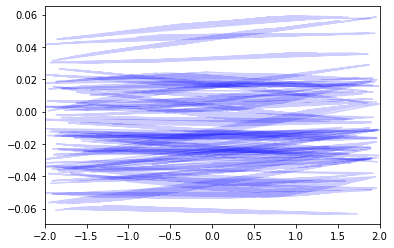

In [13]:
for i in range(50):
  xc, yc, xt, yt = train_list[i]
  z = torch.rand((16, h_size)).to(dev)
  z = z[:, None, :].expand(-1, xt.shape[1], -1)
  mu, sig, distr = np._decoder(xt, z)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.xlim(-2, 2)

In [14]:
# Xavier_Uniform weight init
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

np.apply(init_weights)

NeuralProcess(
  (_encoder): Encoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=512, bias=True)
        (5): ReLU()
        (6): Linear(in_features=512, out_features=1024, bias=True)
      )
    )
    (_map): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
    )
    (_mu): Linear(in_features=128, out_features=128, bias=True)
    (_log_sigma): Linear(in_features=128, out_features=128, bias=True)
  )
  (_decoder): Decoder(
    (_mlp): MLP(
      (linears): ModuleList(
        (0): Linear(in_features=129, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=2, bias=True)
      )
    )
  )
)

# Training

Iteration: 0, loss: 1.1646907329559326


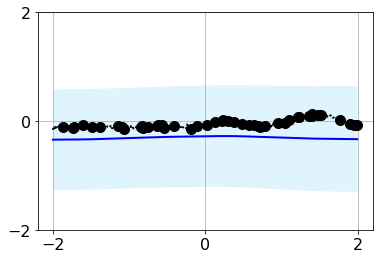

In [15]:
mu, sigma, _ = np._fit(num_iter, save_iter, train_list, test_list, opt)

### Save Neural Process model to Google Drive
Uncomment the code in the following cell to enable this.

In [16]:
# Mount drive
# Source: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
# from google.colab import drive
# drive.mount('/content/gdrive')

# Save model
# Source: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# !mkdir -p /content/gdrive/MyDrive/neural-processes-model
# torch.save(np, '/content/gdrive/MyDrive/neural-processes-model.pt')

In [17]:
# Hotfix for missing HTTP headers in pytorch's HTTP request for MNIST dataset download
# Source:
# https://github.com/pytorch/vision/issues/1938#issuecomment-594623431
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

### Output of predictive distribution after training given random latent Z (not related to stochastic process)


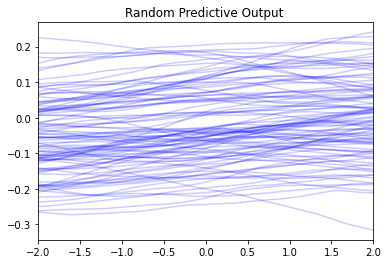

In [18]:
for i in range(len(test_list)):
  xc, yc, xt, yt = test_list[i]
  z = torch.rand((1, h_size)).to(dev)
  z = z[:, None, :].expand(-1, xt.shape[1], -1)
  mu, sig, distr = np._decoder(xt, z)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.title(label='Random Predictive Output ')
  plt.xlim(-2, 2)

### Output of predictive distribution after training given sampled latent Z

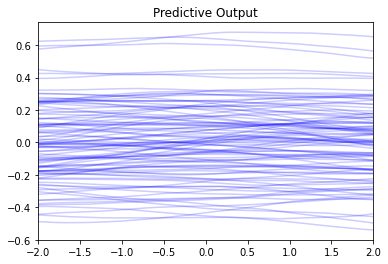

In [19]:
for i in range(len(test_list)):
  xc, yc, xt, yt = test_list[i]
  # z = torch.rand((1, h_size))
  # z = z[:, None, :].expand(-1, xt.shape[1], -1)
  (mu, sig, distr), q = np(xc, yc, xt)
  
  plt.plot(xt.cpu()[0], mu.detach().cpu()[0], 
             c='b', alpha=0.2)
  plt.title(label='Predictive Output')
  plt.xlim(-2, 2)

# Neural Processes for MNIST

In [20]:
# ToTensor() maps to range [0, 1]
# train_mnist = datasets.MNIST('./data', download=True, transform=torchvision.transforms.ToTensor()) 
# test_mnist = datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [21]:
from torchvision import datasets
new_mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist'
datasets.MNIST.resources = [
   ('/'.join([new_mirror, url.split('/')[-1]]), md5)
   for url, md5 in datasets.MNIST.resources
]
train_data = datasets.MNIST(
   "./", train=True, download=True, transform = torchvision.transforms.ToTensor()
)
test_data = datasets.MNIST("./", train=True, download=True, transform = torchvision.transforms.ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found

Failed to download (trying next):
HTTP Error 404: Not Found



RuntimeError: ignored

## Parameters

In [ ]:
if dev.type == 'cuda':
  pin_memory = True
else:
  pin_memory = False

params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 0,
          'pin_memory': pin_memory}
          
train_generator = torch.utils.data.DataLoader(train_mnist, **params)

In [ ]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0,
          'pin_memory': pin_memory}
          
test_generator = torch.utils.data.DataLoader(test_mnist, **params)

In [ ]:
in_features = 2 
h_size = 256
encoder_out = [h_size] # [128, 256, 512, 1024] 
decoder_out = [h_size] + [2] # [512, 256] + [2] 

## Create model

In [ ]:
np = neural_processes.img_model.ImgNeuralProcess(in_features, encoder_out, decoder_out, h_size)

np.apply(init_weights)

np.to(dev)

In [ ]:
# Define optimizer
opt = optim.Adam(np.parameters(), lr=5e-5, eps=1e-07)

## Fit NP model to MNIST dataset

In [ ]:
epochs = 50
save_epoch = 5
mu, sigma, _ = np._fit(epochs, 
                    save_epoch, 
                    train_generator, 
                    test_generator,
                    opt)

In [ ]:
# TODO overfitting 3 classes, avg. epoch loss

In [ ]:
test_set = neural_processes.mnist.preprocess_mnist(test_generator, dev, train=False)

In [ ]:
xc, yc, xt, yt = test_set[6]

In [ ]:
m = torch.zeros(28, 28)
x, y = neural_processes.plot.rescale(xt[0], mu.detach()[0], 'cpu')
xk, yk = neural_processes.plot.rescale(xc[0], yc[0], 'cpu')

num_context = xk.shape[0]

for i, val in enumerate(x):
    
    if i < num_context:
      m[val[0], val[1]] = yk[i]
    else:
      m[val[0], val[1]] = y[i]

plt.imshow(m)